# Detection of Network Packets (Part II)

This is a task from http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html about network traffic packets. There are several kinds of preclassified packets: normal, trojans, viruses, etc.

The KDD99 dataset consists of normal data points and points that have been labeled as Denial of Service (DoS), Remote to User (R2L), User to Root (U2R), and Probing (Probe) by logging network packet information. More information about the dataset can be found at https://kdd.ics.uci.edu/databases/kddcup99/task.html.

Each row of the KDD Cup 99 dataset is a network connection, with a total of 41 independent variables and 1 dependent variable. The independent variables can be broadly divided into three groups:

1. Basic input features of network connections such as duration, protocol type, and number of bytes from source IP addresses
2. Content input features of network connections
3. The statistical input features computed over a time window



## Lab prerequisties

We assume there is a KDD 10% dataset prepared : downloaded, extracted, modified. It's stored in the _pickle_ format.
If you don't have this dataset, please revise the previous Lab and complete section "Preparing Data"

## Load dataset
Locate _.pkl_ file (or the file you specfied during dumping) and load its content into local variables

In [89]:
import pickle

In [90]:
# load data back from pickle file:
pickle_file = './kddcup.data_10_percent.pkl'
with open(pickle_file, 'rb') as f:
    preprocessed_data = pickle.load(f)

# check what's inside:
for key in preprocessed_data:
    print (key)

x_train
x_test
y_train
y_test
le


In [91]:
le = preprocessed_data["le"]
x_train = preprocessed_data["x_train"]
y_train = preprocessed_data["y_train"]
x_test = preprocessed_data["x_test"]
y_test = preprocessed_data["y_test"]

In [92]:
# double check the shapes of the variables, they should match

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(370515, 118)
(370515,)
(123506, 118)
(123506,)


## Gradient Boosting on Trees

Credits:
1. https://xgboost.ai/2016/12/14/GPU-accelerated-xgboost.html
2. https://youtu.be/wPqtzj5VZus
3. https://neerc.ifmo.ru/wiki/index.php?title=XGBoost

XGBoost is widely known today as a "go to" model when working with structured data such as the KDD99 dataset. In fact, there are a disproportionately large number of XGBoost-based winning entries of Kaggle competitions.

What is XGBoost and why is it so popular?


Traditionally, in tree-based ensemble methods such as _Random Forests_, we train each tree independently. The predictions of multiple trees are summed to obtain the final score. The figure below classifies whether someone would like to play computer games or not.


<img src="https://raw.githubusercontent.com/dmlc/web-data/master/xgboost/model/cart.png" alt="Alt text that describes the graphic" title="Title text" width=700px>


**Note!**
**In the case of XGBoost, an implementation of Gradient Boosted Decision Trees, we repeatedly build new models and combine them into an ensemble. Unlike Random Forests, we build trees one at a time, where each new tree helps to correct errors made by previously trained tree.**


The following picture illustrates the combination of trees working as a unified procedure:
<img src="https://raw.githubusercontent.com/dmlc/web-data/master/xgboost/model/twocart.png" alt="Alt text that describes the graphic" title="Title text" width=700px>


The learning process slightly differs from what we used in the Random Forests: next tree isn't being made from scratch, instead it compensates errors from the previous Tree:


<img src="https://drive.google.com/uc?id=1WDN-kDMOsIhY3vWy8UBOR0qgBRHqbf-2" alt="Alt text that describes the graphic" title="Title text" width=700px>


### Why use GPU

Generally, GPU accelerated XGBoost models will train much faster. It’s also extremely easy. In order to use the GPU version of XGBoost, only one parameter in the code has to be set (see below): {'tree_method': 'gpu_hist'} Also, the environment must have the GPU version of XGBoost: https://xgboost.readthedocs.io/en/latest/gpu/index.html.


Machine learning models using XGBoost on large datasets can take several hours to train and achieve the best predictions. Oftentimes, models have to be trained for 1000s of iterations, and usually many different combinations of hyperparameters must be tested.

The more models that can be trained, the better the accuracy will be.

Fortunately, the XGBoost algorithm is highly parallelizable by virtue of requiring scans across gradient values and using these partial sums to evaluate the quality of splits at every possible split in the training set. By utilizing fast parallel prefix operations to scan through all possible splits as well as parallel radix sorting to repartition data, the GPU accelerated version builds a decision tree for a given boosting iteration one level at a time, processing the entire dataset concurrently on the GPU.

### Hyperparamteres tuning

Hyperparameters can have a huge impact on the performance of XGBoost models.
Some of the more important ones are listed below. See [here](https://xgboost.readthedocs.io/en/latest/parameter.html) for a description of all parameters and see [here](https://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html) for a guide to tuning XGBoost models. Feel free to try out different combinations:

**objective:**
Depending on whether we treat our problem as a binary classification problem or as a multi-class classification problem this parameter would be either binary:logistic or multi:softmax respectively.

**tree_method:**
gpu_exact to use the GPU optimized exact greedy algorithm and gpu_hist to use the histogram optimized approximate greedy algorithm. For GPU accelerated XGBoost it is best to use gpu_hist.

**>n_gpus:**
The number of GPUs to use for training.  Note, if using GPU DASK, n_gpus should be set to 1.

**max_depth:**
Increasing this value will give the model more capacity to learn and it will also be more likely to overfit. If using a large max_depth value, make sure to increase the regularization.

**learning_rate:**
Used to control the weighting of new trees added to the model. If using a low value here, then the number of rounds of training should be high.

**num_class:**
    Indicates the number of classes in the label column. For a binary classification problem this should be 2 and the number of classes in the case of a multi-class problem.

# XGBoost

In [94]:
import xgboost as xgb
import numpy as np
from sklearn.metrics import confusion_matrix,accuracy_score
import pickle
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [95]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)

In [96]:
params = {
    'learning_rate': 0.1,
    'n_estimators': 1000,
    'max_depth': 8,
    'max_leaves': 2**8,
    'min_child_weight': 1,
    'gamma': 0,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'multi:softmax',
    'nthread': 4,
    'scale_pos_weight': 1,
    'seed': 27,
    'verbose': True,
    'num_rounds': 10,
    'num_class': le.classes_.size
}
num_rounds = params['num_rounds']
evals = [(dtrain, 'train'), (dtest, 'test')]

In [97]:
model = xgb.train(params, dtrain, num_rounds, evals=evals)

[08:41:29] WARNING: ../src/learner.cc:576: 
Parameters: { "n_estimators", "num_rounds", "scale_pos_weight", "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[08:41:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-mlogloss:2.03500	test-mlogloss:2.03487
[1]	train-mlogloss:1.67009	test-mlogloss:1.67018
[2]	train-mlogloss:1.42059	test-mlogloss:1.42193
[3]	train-mlogloss:1.23117	test-mlogloss:1.23250
[4]	train-mlogloss:1.08064	test-mlogloss:1.08012
[5]	train-mlogloss:0.95389	test-mlogloss:0.95368
[6]	train-mlogloss:0.84697	test-mlogloss:0.847

In [98]:
predictions = model.predict(dtest).astype(int)

In [99]:
index = 0

print('Predicted: ', predictions[index])
print('Actual: ', y_test[index])

Predicted:  18
Actual:  18


In [100]:
accuracy = accuracy_score(y_test, predictions)
print(accuracy)

0.9993522581898855


In [101]:
list(le.classes_)

['back.',
 'buffer_overflow.',
 'ftp_write.',
 'guess_passwd.',
 'imap.',
 'ipsweep.',
 'land.',
 'loadmodule.',
 'multihop.',
 'neptune.',
 'nmap.',
 'normal.',
 'perl.',
 'phf.',
 'pod.',
 'portsweep.',
 'rootkit.',
 'satan.',
 'smurf.',
 'spy.',
 'teardrop.',
 'warezclient.',
 'warezmaster.']

In [102]:
results = confusion_matrix(y_test, predictions)

# also normalize confusion matrix
results = results.astype('float') / results.sum(axis=1)[:, np.newaxis]

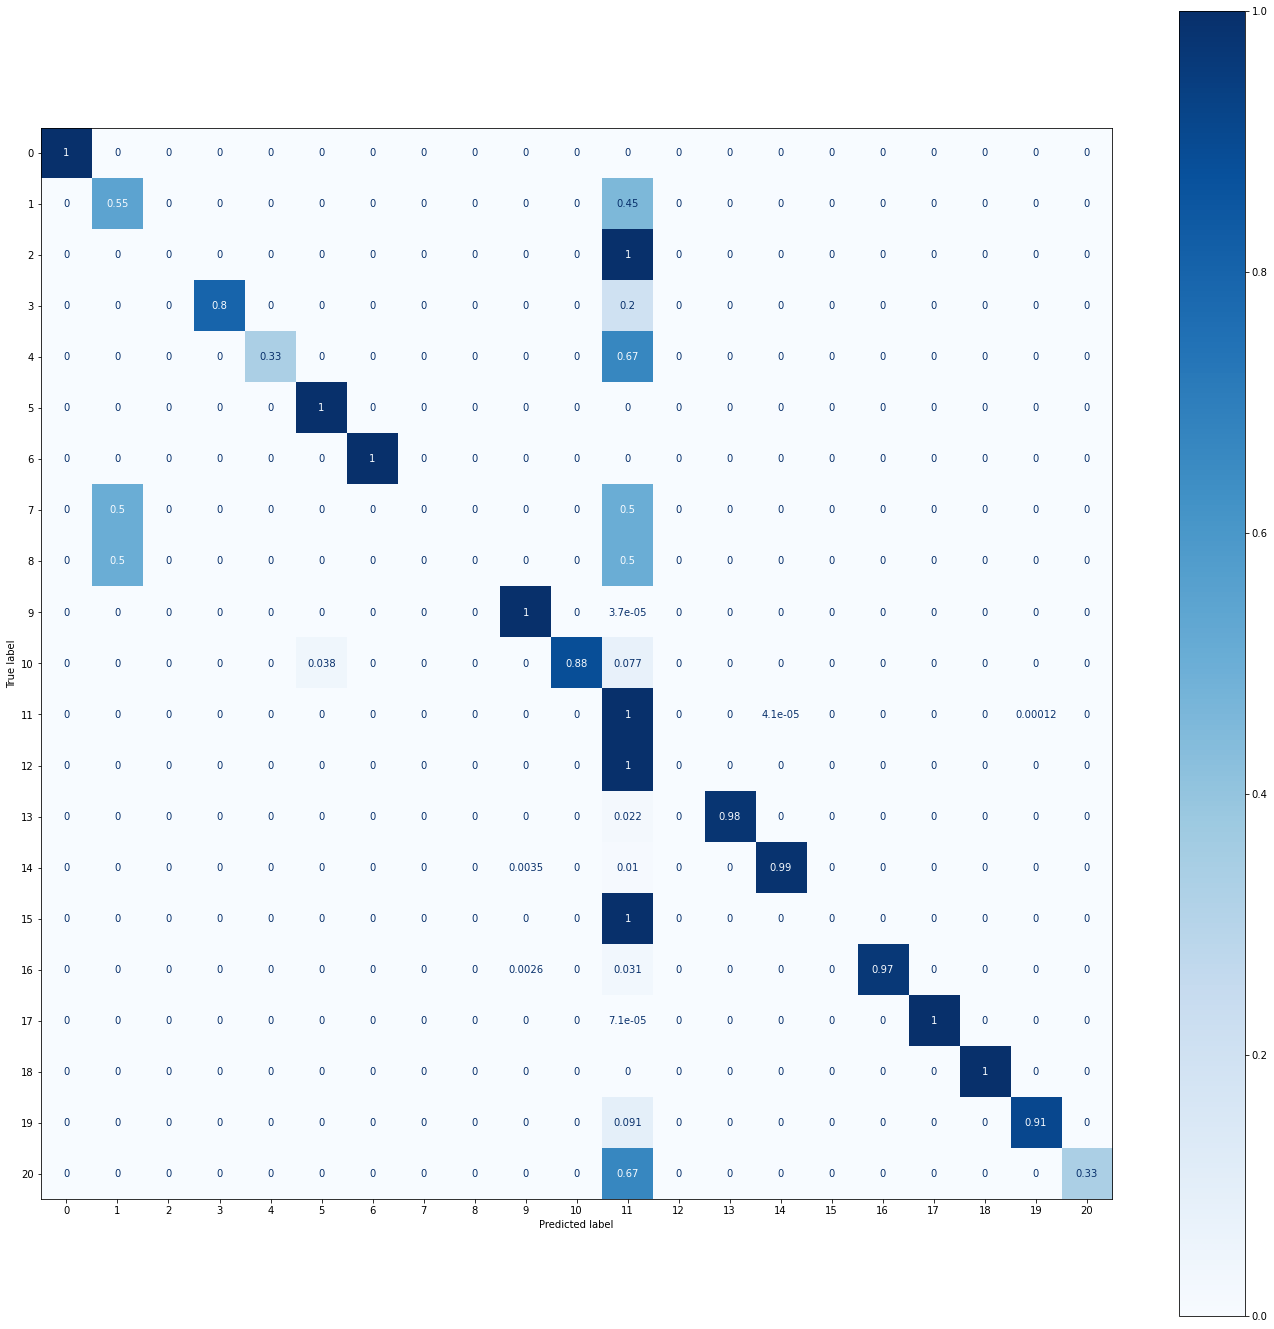

In [103]:
disp = ConfusionMatrixDisplay(confusion_matrix=results)

# NOTE: Fill all variables here with default values of the plot_confusion_matrix
disp = disp.plot(cmap = 'Blues')

plt.rcParams["figure.figsize"] = (24, 24)
plt.show()

# Catboost

In [104]:
import catboost as cb

In [107]:
clf = cb.CatBoostClassifier(eval_metric="AUC", depth=10, iterations= 10, l2_leaf_reg= 9, learning_rate= 0.1)
clf.fit(x_train,y_train)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	total: 5.87s	remaining: 52.9s
1:	total: 11.1s	remaining: 44.2s
2:	total: 15.7s	remaining: 36.7s
3:	total: 20.6s	remaining: 31s
4:	total: 23.5s	remaining: 23.5s
5:	total: 26.5s	remaining: 17.7s
6:	total: 29.4s	remaining: 12.6s
7:	total: 32.5s	remaining: 8.13s
8:	total: 35.4s	remaining: 3.94s
9:	total: 39.3s	remaining: 0us


In [108]:
predictions = clf.predict(x_test)

In [111]:
print(predictions[0])

[18]


In [112]:
accuracy = accuracy_score(y_test, predictions)
print(accuracy)

0.9968746457661976


# TODO: Validation on Full Dataset (extra topic)

In [ ]:
 # download full 100% dataset
 !wget http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data.gz


In [ ]:
# unzip to the local folder
# it contains a .csv file with all the records:
! gzip -d ./kddcup.data.gz

Using the trained model, try to predict classes on fill dataset.

**Hint:**
Reduce samples with not-existed protocol type. Otherwise, there will be more columns after one-hot encoding applied & this won't match the dimension of trained model.